In [1]:
import pymongo
import string
import datetime
import re
import numpy as np
from collections import Counter
from bson.json_util import dumps
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as sk

from sklearn.model_selection import train_test_split
%matplotlib inline 
plt.style.use('fivethirtyeight') # a popular data visualization theme

import nltk
from nltk.corpus import stopwords

In [13]:
#Initialize database
client = pymongo.MongoClient('localhost', 27017)
db = client['yelpdb']

In [18]:
reviews_df = pd.read_json(dumps(list(db['Italian_Reviews'].find())))
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75214 entries, 0 to 75213
Data columns (total 17 columns):
Preprocessed_Text     75214 non-null object
_id                   75214 non-null object
business_id           75214 non-null object
cool                  75214 non-null int64
date                  75214 non-null datetime64[ns]
funny                 75214 non-null int64
review_id             75214 non-null object
stars                 75214 non-null int64
text                  75214 non-null object
useful                75214 non-null int64
user_average_stars    8707 non-null float64
user_cool             8707 non-null float64
user_fans             8707 non-null float64
user_friends          8707 non-null object
user_id               75214 non-null object
user_review_count     8707 non-null float64
user_useful           8707 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(7)
memory usage: 9.8+ MB


In [19]:
reviews_df = reviews_df.drop_duplicates(subset=['user_id', 'review_id'], keep=False)
reviews_df.info()
import json
#df = read_mongo(db, 'Italian_Users')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75214 entries, 0 to 75213
Data columns (total 17 columns):
Preprocessed_Text     75214 non-null object
_id                   75214 non-null object
business_id           75214 non-null object
cool                  75214 non-null int64
date                  75214 non-null datetime64[ns]
funny                 75214 non-null int64
review_id             75214 non-null object
stars                 75214 non-null int64
text                  75214 non-null object
useful                75214 non-null int64
user_average_stars    8707 non-null float64
user_cool             8707 non-null float64
user_fans             8707 non-null float64
user_friends          8707 non-null object
user_id               75214 non-null object
user_review_count     8707 non-null float64
user_useful           8707 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(7)
memory usage: 10.3+ MB


In [20]:
def df_to_json_file(fname, df):
    with open(fname, 'w') as f:
        for row in df.iterrows():
            row[1].to_json(f)
            f.write('\n')

df_to_json_file('Italian_Reviews.json', reviews_df)

In [2]:
#Initialize database
client = pymongo.MongoClient('localhost', 27017)
db = client['yelpdb']

In [4]:
business_df = pd.read_json(dumps(list(db['Italian_Restaurants'].find())))

reviews_df = pd.read_json(dumps(list(db['Italian_Reviews'].find())))
reviews_df = reviews_df[reviews_df.apply(lambda x: 3 != x['stars'], axis=1)]

In [45]:
all_business = pd.read_json(dumps(list(db['restaurants'].find())))

In [23]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65518 entries, 0 to 75213
Data columns (total 17 columns):
Preprocessed_Text     65518 non-null object
_id                   65518 non-null object
business_id           65518 non-null object
cool                  65518 non-null int64
date                  65518 non-null datetime64[ns]
funny                 65518 non-null int64
review_id             65518 non-null object
stars                 65518 non-null int64
text                  65518 non-null object
useful                65518 non-null int64
user_average_stars    7503 non-null float64
user_cool             7503 non-null float64
user_fans             7503 non-null float64
user_friends          7503 non-null object
user_id               65518 non-null object
user_review_count     7503 non-null float64
user_useful           7503 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(7)
memory usage: 9.0+ MB


In [9]:
business_df.head(5)

,_id,attributes,business_id,latitude,longitude,name,neighborhood,review_count,stars
0,{'$oid': '5afee7039954de746fcd38c6'},"{'GoodForMeal': {'dessert': False, 'latenight'...",F0fEKpTk7gAmuSFI0KW1eQ,36.111057,-115.241688,Cafe Mastrioni,Spring Valley,3,1.5
1,{'$oid': '5afee7049954de746fcd38ca'},"{'Alcohol': 'beer_and_wine', 'HasTV': True, 'N...",dPxZI9lrKTl5dvFfnb1_Ig,36.010086,-115.118656,Trattoria Italia,Anthem,210,4.5
2,{'$oid': '5afee7059954de746fcd399d'},"{'GoodForMeal': {'dessert': False, 'latenight'...",uIbZjRRqR1OR-t2NBCa1Wg,36.094457,-115.208867,Pizza Hut,,32,2.5
3,{'$oid': '5afee7069954de746fcd39be'},"{'GoodForMeal': {'dessert': False, 'latenight'...",gtVPsVK83JkeyrN1C1ozeQ,36.168913,-115.138486,Pizza Lotto,Downtown,72,4.0
4,{'$oid': '5afee7069954de746fcd3a07'},"{'GoodForMeal': {'dessert': False, 'latenight'...",OMUe6NNOFEe0VdAouIqAuA,36.128674,-115.198850,Sofia's Cafe,Westside,39,3.5


In [6]:
users_df = pd.read_json(dumps(list(db['Italian_Users'].find())))
users_df.info()

users_df = users_df.drop_duplicates(subset=['user_id', 'name'], keep=False)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55447 entries, 0 to 55446
Data columns (total 23 columns):
_id                   55447 non-null object
average_stars         55447 non-null float64
compliment_cool       55447 non-null int64
compliment_cute       55447 non-null int64
compliment_funny      55447 non-null int64
compliment_hot        55447 non-null int64
compliment_list       55447 non-null int64
compliment_more       55447 non-null int64
compliment_note       55447 non-null int64
compliment_photos     55447 non-null int64
compliment_plain      55447 non-null int64
compliment_profile    55447 non-null int64
compliment_writer     55447 non-null int64
cool                  55447 non-null int64
elite                 55447 non-null object
fans                  55447 non-null int64
friends               55447 non-null object
funny                 55447 non-null int64
name                  55447 non-null object
review_count          55447 non-null int64
useful                554

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44355 entries, 5546 to 49900
Data columns (total 23 columns):
_id                   44355 non-null object
average_stars         44355 non-null float64
compliment_cool       44355 non-null int64
compliment_cute       44355 non-null int64
compliment_funny      44355 non-null int64
compliment_hot        44355 non-null int64
compliment_list       44355 non-null int64
compliment_more       44355 non-null int64
compliment_note       44355 non-null int64
compliment_photos     44355 non-null int64
compliment_plain      44355 non-null int64
compliment_profile    44355 non-null int64
compliment_writer     44355 non-null int64
cool                  44355 non-null int64
elite                 44355 non-null object
fans                  44355 non-null int64
friends               44355 non-null object
funny                 44355 non-null int64
name                  44355 non-null object
review_count          44355 non-null int64
useful                

In [19]:
location_star = business_df[['neighborhood','stars']]
star_for_neighborhood = location_star.groupby(['neighborhood'])
neighborhood_avg_star = star_for_neighborhood.mean()
neighborhood_avg_star['count'] = star_for_neighborhood.count()

neighborhood_avg_star = neighborhood_avg_star.sort_values(['stars'], ascending=False)

print(neighborhood_avg_star.shape, '= (x,y), x = Number of neighborhoods ')
neighborhood_avg_star

(17, 2) = (x,y), x = Number of neighborhoods 


,stars,count
neighborhood,,
The Lakes,4.375000,4
Anthem,4.333333,3
Downtown,3.911765,17
Chinatown,3.875000,4
Westside,3.715909,44
South Summerlin,3.650000,10
Spring Valley,3.633333,45
University,3.625000,4
Summerlin,3.538462,13


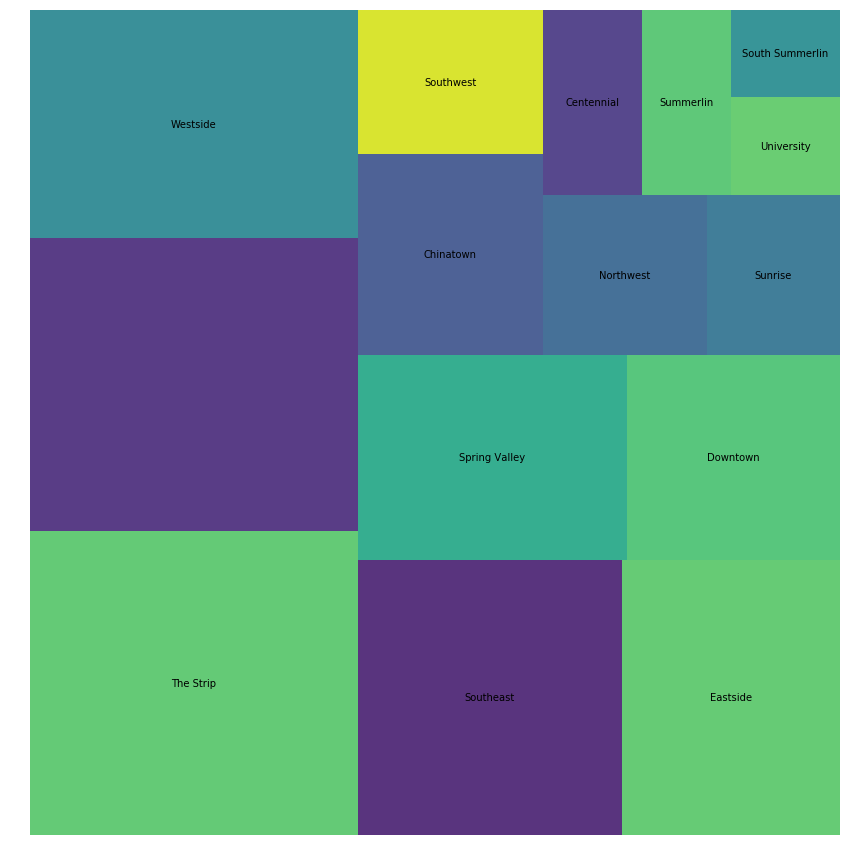

In [50]:
by_state = all_business.groupby('neighborhood')

import squarify    # pip install squarify (algorithm for treemap)
plt.figure(figsize=(12,12))

a = by_state['business_id'].count()

a.sort_values(ascending=False,inplace=True)

squarify.plot(sizes= a[0:15].values, label= a[0:15].index, alpha=0.9)

plt.axis('off')
plt.tight_layout()


In [87]:
business_cats=','.join(all_business['categories'].astype(str))


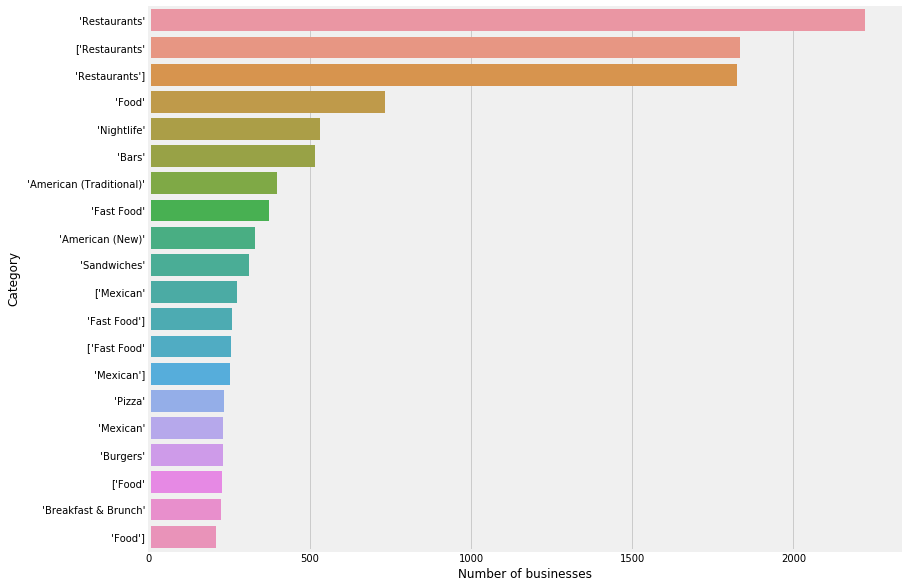

In [88]:

cats=pd.DataFrame(business_cats.split(','),columns=['category'])
cats_ser = cats.category.value_counts()


cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

plt.figure(figsize=(12,10))
f = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
f.set_ylabel('Category')
f.set_xlabel('Number of businesses');

In [91]:
biz_reviews = business_df.merge(reviews_df, on='business_id', how='inner')
#biz_reviews = biz_reviews[['business_id','name','stars_y','text']]

biz_reviews['target'] = biz_reviews.apply(lambda x: 1 == x['stars_y'] or 2 == x['stars_y'], axis=1)

# Create a class-balanced subsample
negative = biz_reviews[biz_reviews.apply(lambda x: 1 == x['stars_y'] or 2 == x['stars_y'], axis=1)]
positive = biz_reviews[biz_reviews.apply(lambda x: 4 == x['stars_y'] or 5 == x['stars_y'], axis=1)]

count_neg = len(negative.index)
count_pos = len(positive.index)
if(count_neg < count_pos):
    down_sample = count_neg/count_pos
    positive = positive.sample(frac=down_sample, random_state=123)
elif(count_neg > count_pos):
    down_sample = count_pos/count_neg
    negative = negative.sample(frac=down_sample, random_state=123)

    
combined = pd.concat([positive, negative])


In [95]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16026 entries, 41614 to 16443
Data columns (total 26 columns):
_id_x                 16026 non-null object
attributes            16026 non-null object
business_id           16026 non-null object
latitude              16026 non-null float64
longitude             16026 non-null float64
name                  16026 non-null object
neighborhood          16026 non-null object
review_count          16026 non-null int64
stars_x               16026 non-null float64
Preprocessed_Text     16026 non-null object
_id_y                 16026 non-null object
cool                  16026 non-null int64
date                  16026 non-null datetime64[ns]
funny                 16026 non-null int64
review_id             16026 non-null object
stars_y               16026 non-null int64
text                  16026 non-null object
useful                16026 non-null int64
user_average_stars    1757 non-null float64
user_cool             1757 non-null float64
u

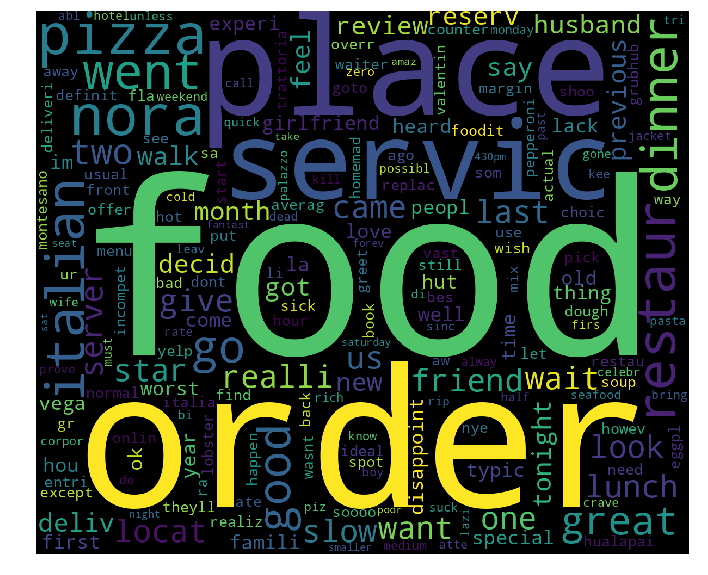

In [99]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='black',
                          width=1200,
                      stopwords = STOPWORDS,
                          height=1000
                         ).generate(str(negative['Preprocessed_Text']))


plt.imshow(wordcloud)
plt.axis('off');

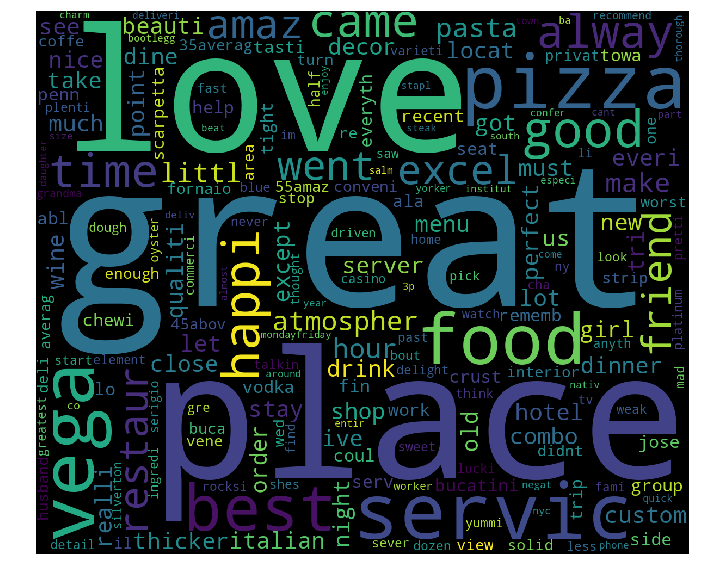

In [98]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='black',
                          width=1200,
                      stopwords = STOPWORDS,
                          height=1000
                         ).generate(str(positive['Preprocessed_Text']))


plt.imshow(wordcloud)
plt.axis('off');

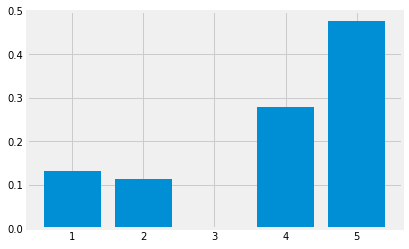

In [27]:
stars = Counter(reviews_df['stars'].values.tolist())

Xs = sorted(list(stars.keys()))
Ys = [stars[key]/len(reviews_df) for key in Xs]
plt.bar(Xs, Ys)
plt.show()

In [31]:
# find the users who have left the most reviews
users = Counter(reviews_df['user_id'].values.tolist())
print(users.most_common(10))


[('bLbSNkLggFnqwNNzzq-Ijw', 47), ('PKEzKWv_FktMm2mGPjwd0Q', 42), ('s2o_JsABvrZVm_T03qrBUw', 42), ('8DEyKVyplnOcSKx39vatbg', 38), ('U4INQZOPSUaj8hMjLlZ3KA', 37), ('UYcmGbelzRa0Q6JqzLoguw', 35), ('C2C0GPKvzWWnP57Os9eQ0w', 33), ('Fv0e9RIV9jw5TX3ctA1WbA', 32), ('QJI9OSEn6ujRCtrX06vs1w', 31), ('ywEB0MB_2U11NIGPs35pew', 28)]


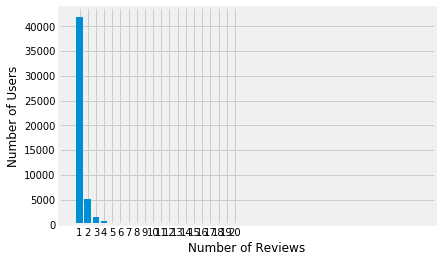

In [33]:
# how many reviews are left by most users

num_reviews_left = Counter([x[1] for x in users.most_common()])

Xs = [x[0] for x in num_reviews_left.most_common()]
Ys = [x[1] for x in num_reviews_left.most_common()]
plt.bar(Xs[:20], Ys[:20]) # we’ll visualise the drop off only up to 20
plt.xticks(range(1,21))
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
plt.show()

In [ ]:
# determine whether good or bad reviews tend to have more words

import statistics
review_lengths_by_star = [[0],[0],[0],[0],[0]]
for index, row in reviews_df.iterrows():
    length = len(row['text'].split())
    idx = row['stars'] - 1
    review_lengths_by_star[idx].append(length)
print([statistics.mean(review_lengths) for review_lengths in review_lengths_by_star])

plt.bar([1, 2, 3, 4, 5], [statistics.mean(rlength) for rlength in review_lengths_by_star])
plt.xlabel("Stars")
plt.ylabel("Word length")
plt.show()


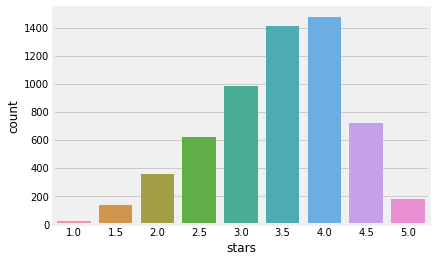

In [47]:
#  visualize the frequency of the ratings
# see that most of the businesses got a rating of either 3 or above
sns.countplot(x='stars',data=all_business)

/home/someone/PycharmProjects/YelpJupyter/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


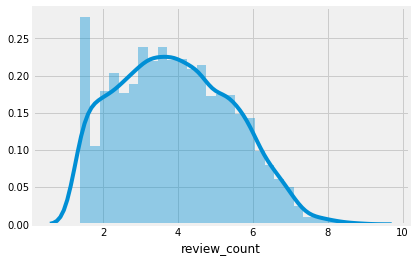

In [46]:
# visualize the distribution of number of reviews that a business has

sns.distplot(all_business['review_count'].apply(np.log1p))